<a href="https://colab.research.google.com/github/asifa1510/LNN/blob/main/full_iplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial MSE: 0.27648
Epoch 0: MSE 0.2387119385
Epoch 100: MSE 0.0282598144
Epoch 200: MSE 0.0098823808
Epoch 300: MSE 0.0064849603
Final MSE: 0.0058744247


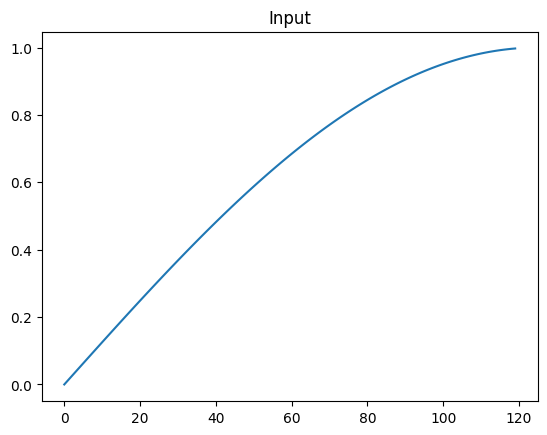

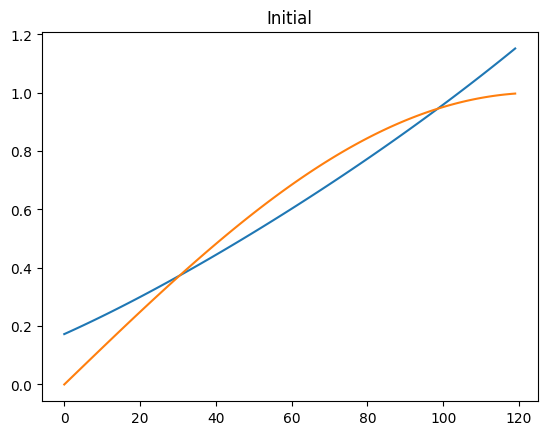

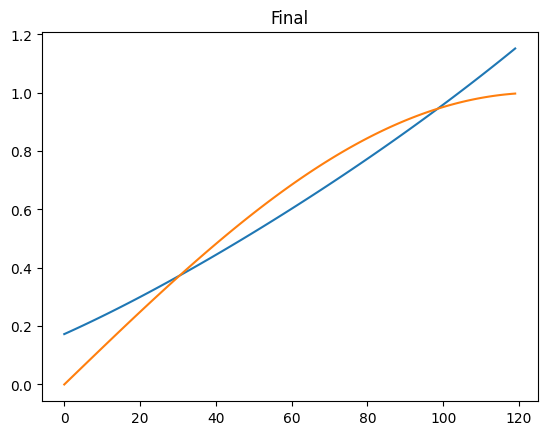

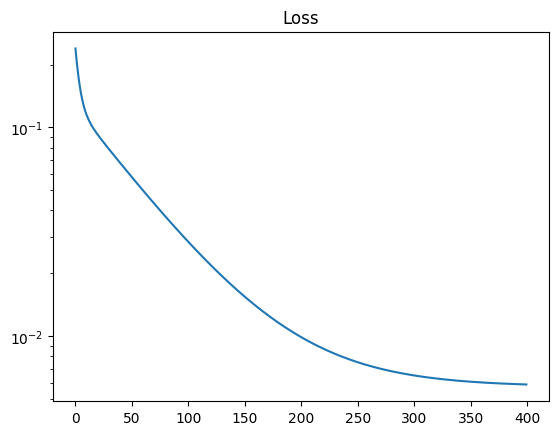

In [1]:
from math import tanh,sin,pi
import random,matplotlib.pyplot as plt

def zeros(n):return[0.0]*n
def mat_zeros(r,c):return[[0.0]*c for _ in range(r)]
def matvec(W,x):return[sum(wij*xj for wij,xj in zip(row,x))for row in W]
def add_vec(a,b):return[a[i]+b[i]for i in range(len(a))]
def sub_vec(a,b):return[a[i]-b[i]for i in range(len(a))]
def mul_scalar(s,v):return[s*x for x in v]
def dot(a,b):return sum(x*y for x,y in zip(a,b))

class LTCCell:
    def __init__(self,N,M,seed=0,scale=0.5):
        random.seed(seed);self.N,self.M=N,M
        self.W_rec=[[random.uniform(-scale,scale)for _ in range(N)]for _ in range(N)]
        self.W_in=[[random.uniform(-scale,scale)for _ in range(M)]for _ in range(N)]
        self.b=[random.uniform(-scale,scale)for _ in range(N)]
        self.tau=[0.8+0.4*random.random()for _ in range(N)]
        self.A=[random.uniform(-0.5,0.5)for _ in range(N)]
        self.W_out=[[random.uniform(-scale,scale)for _ in range(N)]]
        self.b_out=[random.uniform(-scale,scale)]
        self.reset_grad()
    def reset_grad(self):
        self.dW_rec=mat_zeros(self.N,self.N);self.dW_in=mat_zeros(self.N,self.M)
        self.db=zeros(self.N);self.dtau=zeros(self.N);self.dA=zeros(self.N)
        self.dW_out=[[0.0]*self.N];self.db_out=[0.0]
    def step(self,x,u,dt):
        pre=[sum(self.W_rec[i][j]*x[j]for j in range(self.N))+sum(self.W_in[i][m]*u[m]for m in range(self.M))+self.b[i]for i in range(self.N)]
        f=[tanh(p)for p in pre]
        q=[1.0+dt*(1.0/self.tau[i]+f[i])for i in range(self.N)]
        x_next=[x[i]+dt*f[i]*self.A[i]/q[i]for i in range(self.N)]
        y=sum(self.W_out[0][j]*x_next[j]for j in range(self.N))+self.b_out[0]
        return x_next,y,pre,f,q
    def forward(self,x0,inputs,dt):
        x,traj=x0[:],[x0[:]]
        Y,PRE,F,Q=[],[],[],[]
        for u in inputs:
            x_next,y,pre,f,q=self.step(x,u,dt)
            x=x_next
            traj.append(x[:]);Y.append(y);PRE.append(pre);F.append(f);Q.append(q)
        self.traj=traj;self.Y=Y;self.PRE=PRE;self.F=F;self.Q=Q
        return traj,Y
    def backward(self,targets,lr=5e-2):
        T=len(targets);self.reset_grad();dldy=[2*(y-t)/T for y,t in zip(self.Y,targets)]
        for t in range(T-1,-1,-1):
            x_next=self.traj[t];x_prev=self.traj[t-1]if t>0 else zeros(self.N)
            pre=self.PRE[t];f=self.F[t];q=self.Q[t]
            dy_dx_next=[self.W_out[0][j]for j in range(self.N)];dy_db_out=1.0
            self.dW_out[0]=add_vec(self.dW_out[0],mul_scalar(dldy[t],x_next))
            self.db_out[0]+=dldy[t]*dy_db_out
            dldx=[dldy[t]*dy_dx_next[i]for i in range(self.N)]
            for i in range(self.N):
                dx_next_dpre_i=(self.A[i]*dt/q[i])*(1-tanh(pre[i])**2)
                dx_next_dA_i=dt*f[i]/q[i]
                dx_next_dtau_i=dt*f[i]*self.A[i]/(q[i]*self.tau[i]**2)
                dx_next_dx_prev_i=1.0
                dldpre_i=dldx[i]*dx_next_dpre_i
                dldA_i=dldx[i]*dx_next_dA_i
                dldtau_i=dldx[i]*dx_next_dtau_i
                dldx_prev_i=dldx[i]*dx_next_dx_prev_i
                self.dA[i]+=dldA_i;self.dtau[i]+=dldtau_i
                for j in range(self.N):
                    self.dW_rec[i][j]+=dldpre_i*x_prev[j]
                    if t>0:self.dW_rec[i][j]+=dldx_prev_i*(self.W_rec[i][j]*0)
                for m in range(self.M):
                    self.dW_in[i][m]+=dldpre_i*inputs[t][m]
                self.db[i]+=dldpre_i
            if t>0:
                for i in range(self.N):dldx[i]+=dldx_prev_i
        for i in range(self.N):
            for j in range(self.N):self.W_rec[i][j]-=lr*self.dW_rec[i][j]
            for m in range(self.M):self.W_in[i][m]-=lr*self.dW_in[i][m]
            self.b[i]-=lr*self.db[i];self.tau[i]-=lr*self.dtau[i];self.A[i]-=lr*self.dA[i]
            self.W_out[0][i]-=lr*self.dW_out[0][i]
        self.b_out[0]-=lr*self.db_out[0]

T,dt=120,0.05
t_vals=[i*dt for i in range(T)]
inputs=[[sin(2*pi*t/25.0)]for t in t_vals]
targets=[u[0]for u in inputs]
N,M=6,1
cell=LTCCell(N,M,seed=3,scale=0.6)
x0=zeros(N)
X,Y=cell.forward(x0,inputs,dt)
mse0=sum((y-t)**2 for y,t in zip(Y,targets))/T
print("Initial MSE:",round(mse0,6))
losses=[]
for epoch in range(400):
    cell.backward(targets,lr=5e-2)
    X,Y=cell.forward(x0,inputs,dt)
    loss=sum((y-t)**2 for y,t in zip(Y,targets))/T
    losses.append(loss)
    if epoch%100==0:print(f"Epoch {epoch}: MSE {loss:.10f}")
X_f,Y_f=cell.forward(x0,inputs,dt)
mse_f=sum((y-t)**2 for y,t in zip(Y_f,targets))/T
print("Final MSE:",round(mse_f,10))

plt.figure();plt.title("Input");plt.plot([u[0]for u in inputs]);plt.show()
plt.figure();plt.title("Initial");plt.plot(Y);plt.plot(targets);plt.show()
plt.figure();plt.title("Final");plt.plot(Y_f);plt.plot(targets);plt.show()
plt.figure();plt.title("Loss");plt.plot(losses);plt.yscale('log');plt.show()